###1. Import dataset from Kaggle#

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Copy dataset from read-only location to writable working dir

In [3]:
import shutil
shutil.copytree('/kaggle/input/brain-tumor-mri-dataset', '/kaggle/working/brain-tumor-mri-dataset')


'/kaggle/working/brain-tumor-mri-dataset'

##2. Image Pre-processing

###2.1 checking and removing duplicates

In [4]:
import os
PROJECT_DIR = "/kaggle/working/brain-tumor-mri-dataset"

# Folder names used as labels
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
import hashlib

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)


Removing duplicate (hash : 333ca271271562e025951545e76a8b0b) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0249.jpg
Removing duplicate (hash : af3a4cf5d54bd454b733bfe3d2177b4a) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0366.jpg
Removing duplicate (hash : af3a4cf5d54bd454b733bfe3d2177b4a) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0176.jpg
Removing duplicate (hash : b0481c04cf82055b53bed325556f744e) : /kaggle/working/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg
Removing duplicate (hash : a501e6ea3748d3aebea8e8735268ec5b) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0227.jpg
Removing duplicate (hash : 3cb1d6594ea1a7391608e9bc8245529c) : /kaggle/working/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0143.jpg
Removing duplicate (hash : ab525628d00898aa6b1088d9c1d5a785) : /kaggle/working/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0281.jpg
Removing duplicate (hash : 832c3e024

###2.2 verify partitioning of training and testing data to be 80/20 split

In [6]:
import os
from collections import Counter

# Set your dataset root directory
PROJECT_DIR = "/kaggle/working/brain-tumor-mri-dataset"

# Class subfolder names
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Loop through both training and testing folders
for data_type in ['Training', 'Testing']:
    print(f"\n {data_type} Folder:")
    for label in LABELS:
        folder_path = os.path.join(PROJECT_DIR, data_type, label)
        ext_counter = Counter()

        if not os.path.exists(folder_path):
            print(f" Folder not found: {folder_path}")
            continue

        # Count file types
        for file in os.listdir(folder_path):
            if os.path.isfile(os.path.join(folder_path, file)):
                ext = os.path.splitext(file)[-1].lower()
                ext_counter[ext] += 1

        print(f"    {label}/")
        for ext, count in ext_counter.items():
            print(f"    {ext}: {count} files")



 Training Folder:
    glioma/
    .jpg: 1321 files
    meningioma/
    .jpg: 1333 files
    notumor/
    .jpg: 1422 files
    pituitary/
    .jpg: 1445 files

 Testing Folder:
    glioma/
    .jpg: 299 files
    meningioma/
    .jpg: 302 files
    notumor/
    .jpg: 309 files
    pituitary/
    .jpg: 295 files


###2.3 Preprocessing with Keras ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
TRAIN_DIR = "/kaggle/working/brain-tumor-mri-dataset/Training"
TEST_DIR = "/kaggle/working/brain-tumor-mri-dataset/Testing"

#fixed values
image_size = (224, 224)
batch_size = 32

# Create data generators
train_gen = ImageDataGenerator(
    rescale=1./255,              # Normalize
    rotation_range=15,           # Random rotation
    zoom_range=0.1,              # Random zoom
    width_shift_range=0.1,       # Random width shift
    height_shift_range=0.1,      # Random height shift
    brightness_range=[0.7, 1.3],  # Random brightness shift
    horizontal_flip=True,        # Flip horizontally
    validation_split=0.2         # 20% used for validation
)

# Training data (80%)
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

# Validation data (20%)
val_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

# Test data generator (no augmentation, just normalization)
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 4418 images belonging to 4 classes.
Found 1103 images belonging to 4 classes.
Found 1205 images belonging to 4 classes.


##3.Model Building and Training



3.1 Model Building

In [8]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, ReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

# Load base ResNet50 model (without top classifier layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model's convolutional layers except for 30
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build your custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),     # Flatten feature maps

    Dense(512, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),

    Dense(256, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),

    Dense(128, kernel_initializer='he_uniform', use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),

    layers.Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,804,228 (94.62 MB)

 Trainable params: 15,664,900 (59.76 MB)

 Non-trainable params: 9,139,328 (34.86 MB)

3.2 Model Training

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_data.classes

# Get unique class labels
class_labels = np.unique(y_train)

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)

# Convert to dictionary for Keras
class_weight_dict = dict(zip(class_labels, weights))

class_weight = {
    0: 1.5,  # glioma
    1: 2.0,
    2: 0.8,
    3: 1.0
}

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',          # Watch validation loss (can also use 'val_accuracy')
    patience=3,                  # Wait 3 epochs for improvement before stopping
    restore_best_weights=True   # Go back to the best model (not the final one)
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,             # Start with 10 and adjust based on performance
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 146s 850ms/step - accuracy: 0.4575 - loss: 1.5325 - precision: 0.5379 - recall: 0.3087 - val_accuracy: 0.2412 - val_loss: 8.8073 - val_precision: 0.2412 - val_recall: 0.2412
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 578ms/step - accuracy: 0.6163 - loss: 1.1658 - precision: 0.6938 - recall: 0.5118 - val_accuracy: 0.2511 - val_loss: 9.1215 - val_precision: 0.2511 - val_recall: 0.2511
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 85s 608ms/step - accuracy: 0.6399 - loss: 1.1375 - precision: 0.7018 - recall: 0.5393 - val_accuracy: 0.2638 - val_loss: 3.0434 - val_precision: 0.2645 - val_recall: 0.2611
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - accuracy: 0.5516 - loss: 1.3690 - precision: 0.6236 - recall: 0.4512 - val_accuracy: 0.2412 - val_loss: 20.9682 - val_precision: 0.2412 - val_recall: 0.2412
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 580ms/step - accuracy: 0.6388 - loss: 1.1479 - precision: 0.7080 - recall: 0.5265 - val_accuracy: 0.33

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

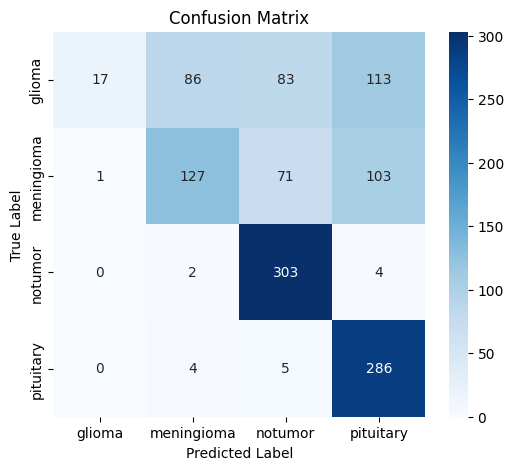

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_generator):
    y_true, y_pred = [], []

    for images, labels in data_generator:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        if len(y_true) >= data_generator.samples:
            break

    class_names = list(data_generator.class_indices.keys())

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run evaluation
evaluate_model(model, test_data)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step


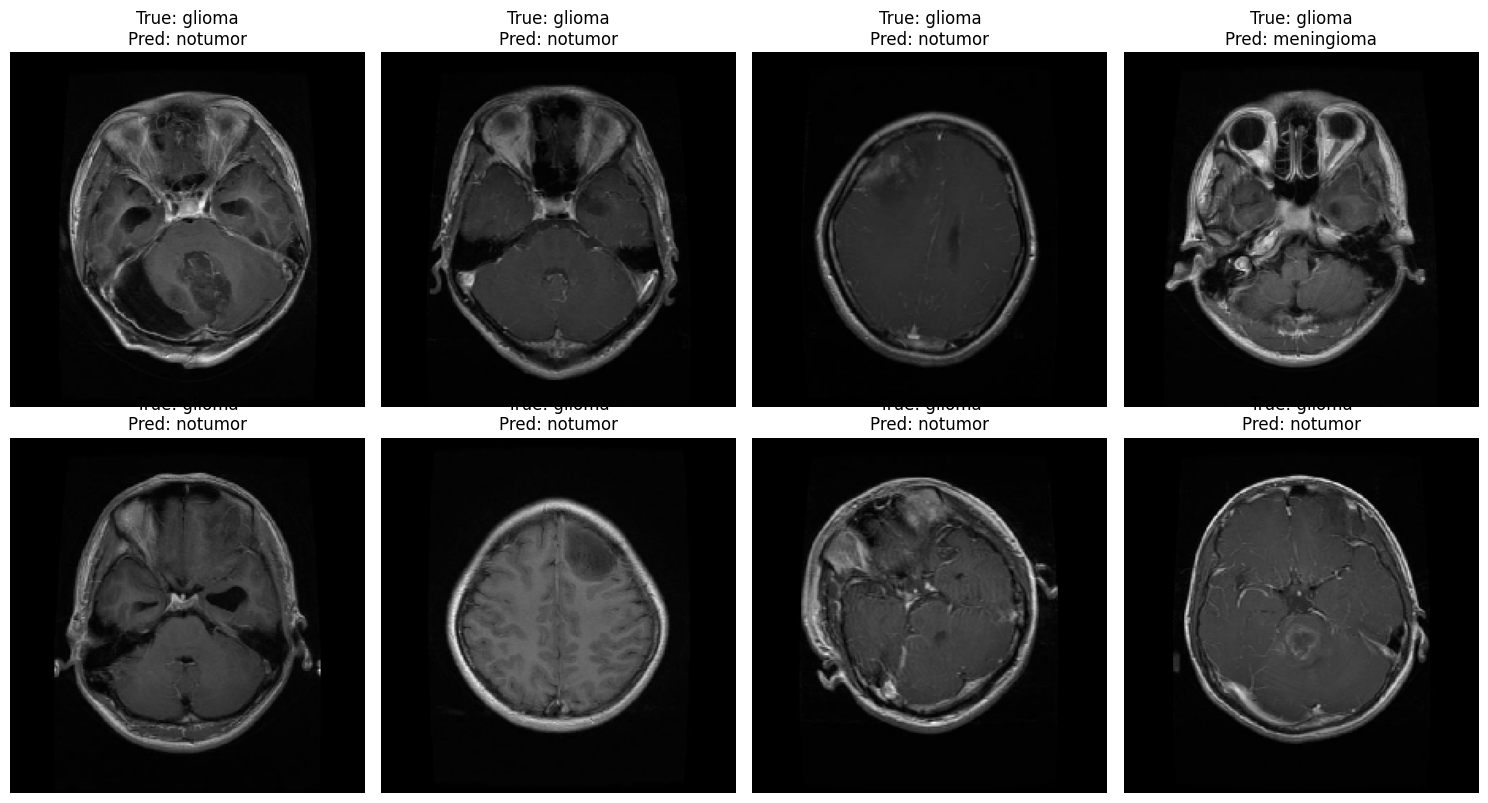

In [12]:
# Get predictions
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_data.classes

# Class label mapping (adjust if needed)
class_names = list(test_data.class_indices.keys())

# Get misclassified pituitary image indices
misclassified_idx = np.where((y_true == 0) & (y_pred_classes != 0))[0]

# Optional: get image batch array
test_images = np.concatenate([test_data[i][0] for i in range(len(test_data))])

# Visualize a few misclassified images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for i, idx in enumerate(misclassified_idx[:8]):
    image = test_images[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred_classes[idx]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
import os
import pickle

# 1) Make sure the folder exists
os.makedirs('models', exist_ok=True)

# 2) Export the model architecture to JSON
model_json = model.to_json()
with open('models/CNN_structure.json', 'w') as json_file:
    json_file.write(model_json)

# 3) Export the weights as a pickle
weights = model.get_weights()          # list of numpy arrays
with open('models/CNN_weights.pkl', 'wb') as weights_file:
    pickle.dump(weights, weights_file)

print("✅ Saved CNN_structure.json and CNN_weights.pkl in models/")


✅ Saved CNN_structure.json and CNN_weights.pkl in models/


In [27]:
from tensorflow.keras.models import model_from_json

# load back architecture
with open('models/CNN_structure.json','r') as f:
    test_json = f.read()
test_model = model_from_json(test_json)

# load back weights
with open('models/CNN_weights.pkl','rb') as f:
    test_weights = pickle.load(f)
test_model.set_weights(test_weights)

# compile exactly like in app.py
import tensorflow as tf
test_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ JSON+Pickle round-trip successful!")


✅ JSON+Pickle round-trip successful!
